#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109/209A Introduction to Data Science Final Project
## Alzheimer's Disease Neuroimaging Initiative
#### Group 16: Daniel Graziano, Daniel Molina-Hurtado, Esmail Fadae, Paxton Maeder-York


In [0]:
####################
#   IMPORTS CELL   #
####################

# ignore warnings for aesthetic reasons
import warnings
warnings.filterwarnings('ignore')

#Basic Imports
import numpy as np
import pandas as pd
import math
import requests

#Preprocessing Imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing.imputation import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Model Imports
from sklearn import svm
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

#Plotting Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

#Keras Imports
import keras 
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils

#Other Imports
from scipy.special import gamma
from IPython.display import display
from typing import List, Tuple, Dict
from io import BytesIO
from sklearn.pipeline import Pipeline
import platform
import warnings


#install and import extra packages not included in base environment
!pip install numba;
!pip install umap-learn;
!pip install graphviz;

if platform.system() == 'Linux':
  !apt-get install graphviz;
elif platform.system() == 'Darwin':
  !brew install graphviz;
else:
  warnings.warn('Please install graphviz binaries to generate decision tree graphs properly','Warning')

import graphviz 
from umap import UMAP

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
#Import data from our shared google drive folder

#file_id comes from the end of the shareable link of the file from google drive
#it is a set of alphanumeric characters after the '/d/ tag in the share URL
#or the 'id' label, see example below
#https://drive.google.com/open?id=1FSjJjpS1Ob_BEbshyl9dXb1FFmCnZrHE
#have to decode the bytes before it can be read by pandas into df

def read_gdrive_data(file_id):
  response = requests.get('https://drive.google.com/uc?export=download&id=%s' % file_id)
  df = pd.read_csv(BytesIO(response.content))
  return df

## Introduction

### Motivation
Alzheimer's Disease (AD) is the 6th leading cause of death in the United States and the [3rd cause among people 65 and older](https://www.nia.nih.gov/news/number-alzheimers-deaths-found-be-underreported). It is an irreversible neurodegenerative disease that progresively damages an individual's cognitive functioning. It usually starts with memory loss and a worsening of thinking capabilities, and it develops to problems with language, orientation and loss of body functions, ultimately leading to death. The life expectancy following the diagnosis of the disease ranges from 3 to 8 years depending on the individual. The disease is significatnly more common in adults in an advanced age, usually over 65 years old.

Currently there is no cure for the disease and the causes are yet not completely understood. Given the relevance of Alzheimer there is a big global effort put in research of diagnosis and treatment. One of the biggest projects is the Alzheimer's Disease Neuroimaging Initiative (ADNI) whose data will be used in this project.

### ADNI

The Alzheimer’s Disease Neuroimaging Initiative is a joint research initiative whose goal is to improve the understanding, diagnosis and treatments for Alzheimer's Disease. As part of this study researchers at more than 60 sites in the United States and Canada collected and are colecting data from over a thousand participants. The types of data collected range from demographics and family history to genetics, neuropsycologichal tests, imaging or biomarkers. The project is divided in several phases in time: ADNI1 (2004-2009), ADNIGO (2009-2001), ADNI2 (2011-2016) and ADNI3 (2016-2021).

<table>
  <tr></tr>
  <tr>
    <td>
      <img src="http://drive.google.com/uc?export=view&id=1d3P68jeOS29j2MtfXFB1mGyUh-PZ6aj8">
    </td>
  </tr>
</table>

### Objectives

Our main goals for this projects are:

1) To build a model able to predict if Alzheimer's disease will be developed in an individual using the data provided by ADNI. This is very important since early diagnosis of Alzheimer can lead to a slower progression of the disease by accessing different treatments [[source]](https://www.alz.org/alzheimers-dementia/diagnosis/why-get-checked).

2) To identify the most relevant information or tests that allow us predicting a diagnosis. This can help reducing the cost and effort spent in the diagnosis phase by reducing the number of tests to the most essential.


## Exploratory Data Analysis (EDA)

The ADNI project collected and is collecting an enormous amount of data that is provided in many scattered csv files and with quite cryptic labels and codes. This together with the lack of knowledge in the field can be overwhelming and challenging at first. In this section we are going to explore different types of data and determine their relevance.

### Data Categories
In order to start having a big picture of the data, we are going to describe roughly the different categories in which we will focus. After doing some research online and taking a look to the data, we have decided to limit our scope to the following categories:

#### Demographics and Medical History
The study collected some basic information about the patients including age, gender, race or civil status. It also collected some family history information like the fact that certain relatives developed different kinds of illnesses including Alzheimer itself. This category of information is the easiest to understand since it doesn't require any particular background.

#### Neuropsychological Tests
One of the most valuable and broadly used information provided as part of the study are neuropsychological tests. This often consists on a set of tasks the patient has to perform and the goal is to evaluate the cognitive function of the brain. They are often focused on a specific part or pathway of this organ and they produce a particular score that is then evaluated in a predefined scale. Some of the most widely used neuropsychological tests include CDR (Clinical Dementia Rating), FAQ (Functional Activities Questionnaire) or MMSE (Mini–Mental State Examination).

#### Biomarkers
A biomarker is some biological indicator that is linked to a particular disease, in this case Alzheimer. The study perform many biological tests to the patients including different blood or urine tests. However one of the most used substances to obtain biomarkers from is the Cerebrospinal Fluid (CSF) which is found in the brain and the spinal cord. Some CSF biomarkers are different forms of the proteins Amyloid-$\beta$ like A$\beta$42 or Tau like p-tau.

<table>
  <tr></tr>
  <tr>
    <td>
      <img src="http://drive.google.com/uc?export=view&id=15Kut9jOo0LrE76C8sFlRFTijVGGKPlXS">
    </td>
  </tr>
</table>

#### Brain Imaging Data
Along the different phases of the study 2 main technologies have been used to capture images of the brain: Magnetic Resonance Imaging (MRI) and Positron Emission Tomography (PET). During the development of Alzheimer Disease many changes happen in the brain including variations in shape and volume, and deposits of toxic proteins like the aforementioned amyloid plaques and tau tangles in certain areas of the brain.

<table>
  <tr></tr>
  <tr>
    <td>
      <img src="http://drive.google.com/uc?export=view&id=1WaFRd-c0_c4QRl_w3Y3RchGcrRNusD1y">
    </td>
    <td>
      <img src="http://drive.google.com/uc?export=view&id=12wH512111-ZXZ8mesI_SRsAaACfVCqBI">
    </td> 
     <tr></tr>
      <tr>
        <td style="text-align:center"><i>Healthy (left) vs AD (right) brain</i></td>
        <td style="text-align:center"><i>MRI Image of the brain</i></td>
      </tr>
</table>


### Datasets Exploration and Merge

In this section we are going to investigate several datasets and merge the ones we consider more relevant into a single dataset. This task is quite complicated for 3 reasons: there is a lot of data, the labels are not very descriptive, and background information is needed to understand many of the tests. Luckily there are a few useful resources provided in the ADNI website like a data dictionary, and some documents that helps us on this task.

In [0]:
# UTILITY FUNCTIONS FOR EDA

# Drops any column not in columns_to_keep
def drop_columns(df: pd.DataFrame, columns_to_keep: np.array) -> pd.DataFrame:
    columns_to_drop = df.columns[np.isin(df.columns, columns_to_keep, invert=True)]
    return df.drop(columns_to_drop, axis=1)

# Wraps pandas merge functions to inform of the number of extra rows created on each merge
def merge_dfs(left_df: pd.DataFrame, 
              right_df: pd.DataFrame, 
              right_columns: List[str], 
              on: List[str], 
              how: str='outer') -> pd.DataFrame:
    
    # merge
    df = pd.merge(left_df, 
                  right_df[right_columns],
                  on=on,
                  how=how)

    n_added_rows = df.shape[0] - left_df.shape[0]
    print("Number of rows increased by : {}".format(n_added_rows))
    return df

# filter failed screenings for ADNI1 phase
def drop_adni1_failed_screenings(df):
    return df[df['VISCODE'] != 'f']
    
# in ADNI1 we do not have screening visites registered, only basline
def swap_adni1_sc_for_bl(df):
    df.loc[(df['VISCODE']=='sc')&(df['Phase']=='ADNI1'), ['VISCODE', 'VISCODE2']] = 'bl'
    return df

# combines the above 2 functions
def adapt_adni1_viscodes(df):
    return swap_adni1_sc_for_bl(drop_adni1_failed_screenings(df))

# replaces -4 and -1 (adni for missing values) with NaN
def replace_missing_values_with_nan(df):
    return df.replace([-4, -1, '-4', '-1'], np.NaN)
    
### Functions to separate patients per study ###
def get_adni1_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI1')
                  & (df['VISCODE'] == 'bl')
                  & (df['RGCONDCT'] == 1), 'RID'].values

def get_adnigo_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNIGO')
                  & (df['VISCODE'] == 'bl')
                  & (df['PTSTATUS'] == 1), 'RID'].values

def get_adni2_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI2')              
                  & (df['VISCODE'] == 'v03')
                  & (df['RGSTATUS'] == 1)
                  & (df['DXCHANGE'].notnull()), 'RID'].values

def get_adni1go_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNIGO')                  
                  & (df['PTSTATUS'] == 1)
                  & (df['RID'] < 2000)
                  & (df['DXCHANGE'].notnull()), 'RID'].values

def get_adni1go2_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI2')
                  & (df['VISCODE'] == 'v06')
                  & (df['RGSTATUS'] == 1)
                  & (df['DXCHANGE'].notnull())
                  & (df['RID'] < 2000), 'RID'].values

def get_adnigo2_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI2')
                  & (df['VISCODE'] == 'v06')
                  & (df['RGSTATUS'] == 1)
                  & (df['DXCHANGE'].notnull())
                  & (df['RID'] < 5000)
                  & (df['RID'] >= 2000), 'RID'].values

def separate_adni_patients_per_phases(df):  
    adni1_rids = get_adni1_patients_rids(df)
    print('ADNI1 patients: ' + str(adni1_rids.shape))

    adnigo_rids = get_adnigo_patients_rids(df)
    print('ADNIGO patients: ' + str(adnigo_rids.shape))
    
    adni2_rids = get_adnig2_patients_rids(df)
    print('ADNI2 patients: ' + str(adni2_rids.shape))

    adni1_go_rids = get_adni1go_patients_rids(df)
    print('ADNI1->ADNIGO patients: ' + adni1_go_rids.shape)

    adni1_go_2_rids = get_adni1go2_patients_rids(df)
    print('ADNI1->ADNIGO->ADNI2 patients: ' + adni1_go_2_rids.shape)

    adnigo_2_rids = get_adnigo2_patients_rids(df)
    print('ADNIGO->ADNI2 patients: ' + adnigo_2_rids.shape)

    all_valid_rids = np.append(np.append(adni1_rids, adnigo_rids), adni2_rids)
    print(all_valid_rids.shape)

    return df, adni1_rids, adnigo_rids, adni2_rids, adni1_go_rids, adni1_go_2_rids, adnigo_2_rids, all_valid_ids
    

#### Diagnosis

We will start from the diagnosis dataset, in which we have the diagnosis given to the patients in different visits and phases. The challenge with this dataframe is that the way diagnosis was presented is varies between phases of the study. The first thing we need to do is create only one diagnosis variable that we can use as our response variable.

In [0]:
# Diagnosis
#dx_df = pd.read_csv('data/DXSUM_PDXCONV_ADNIALL.csv')
dx_df = read_gdrive_data('1kFSq18g-iqGwPzSxld30RbJy94FSa5y3')
dx_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'DXCHANGE', 'DXCURREN', 'DXCONV', 'DXCONTYP', 'DXREV', 'DXNORM', 'DXNODEP', 'DXMCI', 'DXMDES', 'DXMPTR1', 'DXMPTR2', 'DXMPTR3', 'DXMPTR4', 'DXMPTR5', 'DXMPTR6', 'DXMDUE', 'DXMOTHET', 'DXMOTHSP', 'DXDSEV', 'DXDDUE', 'DXAD', 'DXADES', 'DXAPP', 'DXAPROB', 'DXAMETASP', 'DXAOTHRSP', 'DXAPOSS', 'DXAATYSP', 'DXAMETSP', 'DXAOTHSP', 'DXPARK', 'DXPARKSP', 'DXPDES', 'DXPCOG', 'DXPATYP', 'DXPOTHSP', 'DXDEP', 'DXDEPSP', 'DXOTHDEM', 'DXODES', 'DXOOTHSP', 'DXCONFID', 'DIAGNOSIS', 'update_stamp'], dtype='object')

In [0]:
def process_diagnosis(df: pd.DataFrame) -> pd.DataFrame:
    # adapt values from ADNI 1 to ADNI2/3 style
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==1), 'DXCHANGE'] = 1
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==2), 'DXCHANGE'] = 2
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==3), 'DXCHANGE'] = 3
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==1), 'DXCHANGE'] = 4
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==3), 'DXCHANGE'] = 5
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==2), 'DXCHANGE'] = 6
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==1), 'DXCHANGE'] = 7
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==2), 'DXCHANGE'] = 8
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==3), 'DXCHANGE'] = 9
    
    # unify all values and create DX column
    # DXCHANGE=1,7,9 -> Normal (NL)
    # DXCHANGE=2,4,8 -> Mild Cognitive Impairment (MCI)
    # DXCHANGE=3,5,6 -> Dementia (D), we are going to consider it as Alzehimer's Disease (AD)    
    df.loc[(df['DXCHANGE'].isin([1,7,9])), 'DX'] = 'NL'
    df.loc[(df['DXCHANGE'].isin([2,4,8])), 'DX'] = 'MCI'
    df.loc[(df['DXCHANGE'].isin([3,5,6])), 'DX'] = 'AD'
    
    # drop undesired columns
    # VISCODE: original visit code
    # VISCODE2: visit codes transformed to be homogeneus
    columns_to_keep = ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'DX']
    df = drop_columns(df, columns_to_keep)
    
    return df

In [0]:
adni_merge_df = process_diagnosis(dx_df)
display(adni_merge_df.head())
adni_merge_df.shape

,Phase,RID,VISCODE,VISCODE2,DX
0,ADNI1,2,bl,bl,NL
1,ADNI1,3,bl,bl,AD
2,ADNI1,5,bl,bl,NL
3,ADNI1,8,bl,bl,NL
4,ADNI1,7,bl,bl,AD


(11265, 5)

#### Registry

The registry dataset contains dates and some other extra information about all the patient's visits. We are mostly interested in the exam dates but there are some other variables that will help us knowing if the patients actually attended their appointments.

In [0]:
#registry_df = pd.read_csv('data/REGISTRY.csv')
registry_df = read_gdrive_data('1OlbrZi4dUjSBIBtVMUKx7rmQzfFlG8vE')
registry_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'PTSTATUS', 'RGSTATUS', 'VISTYPE', 'EXAMDATE', 'RGCONDCT', 'RGREASON', 'RGOTHSPE', 'RGSOURCE', 'RGRESCRN', 'RGPREVID', 'CHANGTR', 'CGTRACK', 'CGTRACK2', 'update_stamp'], dtype='object')

In [0]:
# VISTYPE: 
# 1=Standard; 2=Non-standard; 3=Not done (not ADNI3)
# 1=In Clinic Visit; 2=Telephone Visit; 3=Telephone Neuropathology Follow-up; 4=Not done (ADNI3)
# RGCONDCT: Was this visit conducted? 
# 1=Yes; 0=No (ADNI1)
# PTSTATUS:
# 1=Active; 2=Discontinued from follow up, will not return (ADNIGO, ADNI2)
# RGSTATUS: Was a screening visit/ADNI2 initial visit performed? 
# 1=Yes; 0=No (ADNI2)
# EXAMDATE: the date of the examination
def process_registry(df: pd.DataFrame) -> pd.DataFrame:
    
    # drop undesired columns
    columns_to_keep = ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'PTSTATUS', 'RGSTATUS', 'RGCONDCT', 'VISTYPE', 
                       'EXAMDATE']    
    df = drop_columns(df, columns_to_keep)
    
    # missing values to NaN
    df = replace_missing_values_with_nan(df)
    
    # filter missing visit values
    df = df[df['VISTYPE'].notnull()
            | df['RGCONDCT'].notnull()]
    
    # filter non-conducted visits
    df = df[((df['VISTYPE'].isin([1,2])) & (df['Phase']!='ADNI3'))
             | ((df['VISTYPE'].isin([1,2,3])) & (df['Phase']=='ADNI3'))
             | ((df['RGCONDCT'] == 1) & (df['Phase']=='ADNI1'))]
    
    
    return df

In [0]:
registry_df = process_registry(registry_df)
print(registry_df.shape)
registry_df.head()

(17230, 9)


,Phase,RID,VISCODE,VISCODE2,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT
9,ADNI1,2,bl,bl,NaN,NaN,NaN,2005-09-08,1.0
12,ADNI1,3,bl,bl,NaN,NaN,NaN,2005-09-12,1.0
13,ADNI1,5,bl,bl,NaN,NaN,NaN,2005-09-07,1.0
21,ADNI1,8,bl,bl,NaN,NaN,NaN,2005-09-19,1.0
32,ADNI1,7,bl,bl,NaN,NaN,NaN,2005-10-06,1.0


In [0]:
adni_merge_df = pd.merge(adni_merge_df, 
                              registry_df,
                              on=['RID', 'Phase', 'VISCODE', 'VISCODE2'],
                              how='outer')
display(adni_merge_df.head())
adni_merge_df.shape

,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0


(17240, 10)

#### Demographics

We are also intereted in some demographic information about the patients:

In [0]:
#demog_df = pd.read_csv('data/PTDEMOG.csv')
demog_df = read_gdrive_data('1dutaXFPBw9CsnNWcZ9YZmej1rsojFKbI')
demog_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'PTSOURCE', 'PTGENDER', 'PTDOBMM', 'PTDOBYY', 'PTHAND', 'PTMARRY', 'PTEDUCAT', 'PTWORKHS', 'PTWORK', 'PTWRECNT', 'PTNOTRT', 'PTRTYR', 'PTHOME', 'PTOTHOME', 'PTTLANG', 'PTPLANG', 'PTPSPEC', 'PTCOGBEG', 'PTMCIBEG', 'PTADBEG', 'PTADDX', 'PTETHCAT', 'PTRACCAT', 'update_stamp'], dtype='object')

In [0]:
#PTGENDER: 1=Male; 2=Female
#PTMARRY: 1=Married; 2=Widowed; 3=Divorced; 4=Never Married; 5=Unknown
#PTRACCAT: 1=American Indian or Alaskan Native; 2=Asian; 3=Native Hawaiian or Other Pacific Islander;
#          4=Black or African American; 5=White; 6=More than one race; 7=Unknown
#PTETHCAT: 1=Hispanic or Latino; 2=Not Hispanic or Latino; 3=Unknown
#PTEDUCAT: years of education
#PTDOBMM, PTDOBYY: year and month of birth
def process_demographics(df: pd.DataFrame) -> pd.DataFrame:
     
    # adapt VISCODE to prevent duplication of rows
    df = adapt_adni1_viscodes(df)
    
    return df


In [0]:
demog_df = process_demographics(demog_df)
display(demog_df.head())
demog_df.shape

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSOURCE,PTGENDER,PTDOBMM,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTWORKHS,PTWORK,PTWRECNT,PTNOTRT,PTRTYR,PTHOME,PTOTHOME,PTTLANG,PTPLANG,PTPSPEC,PTCOGBEG,PTMCIBEG,PTADBEG,PTADDX,PTETHCAT,PTRACCAT,update_stamp
0,ADNI1,18,2,107,bl,bl,2005-08-17,NaN,1,1.0,4.0,1931.0,2.0,1.0,16.0,-4.0,computer progammer,computer programmer,1.0,--/--/1989,1.0,-4,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2005-08-17 00:00:00.0
2,ADNI1,22,3,107,bl,bl,2005-08-18,NaN,1,1.0,5.0,1924.0,1.0,1.0,18.0,-4.0,chemical engineer,chemical engineer,1.0,9/18/1989,3.0,-4,1.0,1.0,-4,NaN,NaN,1999.0,NaN,2.0,5.0,2005-08-18 00:00:00.0
3,ADNI1,24,4,10,bl,bl,2005-08-18,NaN,1,1.0,1.0,1938.0,1.0,1.0,10.0,-4.0,Raw Material Analyzin,Mechanic,0.0,-4,1.0,-4,2.0,2.0,-4,NaN,NaN,-4.0,NaN,1.0,5.0,2005-08-18 00:00:00.0
4,ADNI1,26,5,107,bl,bl,2005-08-23,NaN,1,1.0,12.0,1931.0,1.0,1.0,16.0,-4.0,engineer,engineer,1.0,12/1/1987,1.0,-4,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2005-08-23 00:00:00.0
5,ADNI1,28,7,10,bl,bl,2005-08-25,NaN,1,1.0,4.0,1930.0,1.0,1.0,10.0,-4.0,Factory printing boxes,factory printing boxes,1.0,--/--/1995,1.0,-4,2.0,2.0,-4,NaN,NaN,2002.0,NaN,1.0,6.0,2005-08-25 00:00:00.0


(3794, 32)

In [0]:
adni_merge_df = merge_dfs(adni_merge_df, 
                          demog_df,
                          ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'PTGENDER', 'PTDOBMM', 'PTDOBYY', 'PTMARRY',
                           'PTEDUCAT', 'PTETHCAT', 'PTRACCAT'],
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2'])

# Remove some values that only contains demographics screening after some exploration
adni_merge_df = adni_merge_df[(adni_merge_df['DX'].notnull()) 
                              | (adni_merge_df['EXAMDATE'].notnull())]

display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 13


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0


(17244, 17)

#### Medical History

Let us take a look to the medical history and select some predictors:

In [0]:
#med_hist_df = pd.read_csv('data/MEDHIST.csv')
med_hist_df = read_gdrive_data('1ppPKmBpEh7zOuQCnTPTJ2CV-NKs9npbi')
med_hist_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'MHSOURCE', 'MHPSYCH', 'MH2NEURL', 'MH3HEAD', 'MH4CARD', 'MH5RESP', 'MH6HEPAT', 'MH7DERM', 'MH8MUSCL', 'MH9ENDO', 'MH10GAST', 'MH11HEMA', 'MH12RENA', 'MH13ALLE', 'MH14ALCH', 'MH14AALCH', 'MH14BALCH', 'MH14CALCH', 'MH15DRUG', 'MH15ADRUG', 'MH15BDRUG', 'MH16SMOK', 'MH16ASMOK', 'MH16BSMOK', 'MH16CSMOK', 'MH17MALI', 'MH18SURG', 'MH19OTHR', 'MHCOMMEN', 'update_stamp'], dtype='object')

In [0]:
# adapt VISCODE to prevent duplication of rows
med_hist_df = adapt_adni1_viscodes(med_hist_df)
display(med_hist_df.head())
med_hist_df.shape

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,MHSOURCE,MHPSYCH,MH2NEURL,MH3HEAD,MH4CARD,MH5RESP,MH6HEPAT,MH7DERM,MH8MUSCL,MH9ENDO,MH10GAST,MH11HEMA,MH12RENA,MH13ALLE,MH14ALCH,MH14AALCH,MH14BALCH,MH14CALCH,MH15DRUG,MH15ADRUG,MH15BDRUG,MH16SMOK,MH16ASMOK,MH16BSMOK,MH16CSMOK,MH17MALI,MH18SURG,MH19OTHR,MHCOMMEN,update_stamp
0,ADNI1,8,2,107,bl,bl,2005-08-17,NaN,2005-08-17,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,0,0,-4,2005-08-17 00:00:00.0
2,ADNI1,12,3,107,bl,bl,2005-08-18,NaN,2005-08-18,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,1,1,0,-4,2005-08-18 00:00:00.0
3,ADNI1,14,4,10,bl,bl,2005-08-18,NaN,2005-08-18,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,0,1,0,-4,2005-08-18 00:00:00.0
4,ADNI1,16,5,107,bl,bl,2005-08-23,NaN,2005-08-23,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,0,1,0,-4,2005-08-23 00:00:00.0
5,ADNI1,18,7,10,bl,bl,2005-08-25,NaN,2005-08-25,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,0,0,1,-4,2005-08-25 00:00:00.0


(2749, 39)

In [0]:
#MHPSYCH, MH2NEURL: psychiatric history or neurological history
#MH14ALCH, 'MH15DRUG': alcohol or drug abuse
adni_merge_df = merge_dfs(adni_merge_df, 
                          med_hist_df,
                          ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'MHPSYCH', 'MH2NEURL', 'MH14ALCH' , 'MH15DRUG'],
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2'])

adni_merge_df = adni_merge_df[(adni_merge_df['DX'].notnull()) 
                              | (adni_merge_df['EXAMDATE'].notnull())]

display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 3


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,MHPSYCH,MH2NEURL,MH14ALCH,MH15DRUG
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0,1.0,0.0,0.0,0.0


(17244, 21)

#### Neuropsychological Tests

Neuropsychological tests follow quite a common pattern, we have many columns corresponding to particular questions of the test and then we have a total score. In some cases like ADAS, one have to actually combine some rows or do some pre-processing for the final values to be populated.

##### CDR
Clinical Dementia Rating (CDR) test assesses cognitive and functional performance in six areas: 
- memory 
- orientation
- judgment and problem solving
- community affairs
- home & hobbies
- personal care

Scoring:
- 0 = None
- 0.5 = Very Mild
- 1 = Mild
- 2 = Moderate
- 3 = Severe

Evaluation:
The score in independent areas are combined to obtain a composite score ranging from 0 through 3

In [0]:
#cdr_df = pd.read_csv('data/' + 'CDR.csv')
cdr_df = read_gdrive_data('1QUwihXlPcnwkpfRFz1IsUtmzSY2Bm8_Y')
cdr_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'CDSOURCE', 'CDVERSION', 'CDMEMORY', 'CDORIENT', 'CDJUDGE', 'CDCOMMUN', 'CDHOME', 'CDCARE', 'CDGLOBAL', 'CDRSB', 'CDSOB', 'update_stamp'], dtype='object')

In [0]:
# preprocessing
cdr_df = adapt_adni1_viscodes(cdr_df)
cdr_df = replace_missing_values_with_nan(cdr_df)
cdr_df = cdr_df[cdr_df['CDGLOBAL'].notnull()]
# merge
adni_merge_df = merge_dfs(adni_merge_df, 
                          cdr_df,
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'CDGLOBAL'],
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2'])
display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 11


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,MHPSYCH,MH2NEURL,MH14ALCH,MH15DRUG,CDGLOBAL
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0


(17255, 22)

##### FAQ
The Functional Activities Questionnaire (FAQ) is a 10 question test that measures instrumental activities of daily living (IADLs), such as preparing balanced meals and managing personal finances.

Scoring:
- Dependent = 3
- Requires assistance = 2
- Has difficulty but does by self = 1
- Normal = 0
- Never did [the activity] but could do now = 0
- Never did and would have difficulty now = 1

Evaluation:
Sum individual scores (range will be 0-30). A cut point of 9 (dependent in 3 or more activities) is recommended to indicate impaired function and possible cognitive impairment.

In [0]:
#faq_df = pd.read_csv('data/' + 'FAQ.csv')
faq_df = read_gdrive_data('1jS7lMzUjoAEOCpf_kfwJf-OiTfiZF5vz')
faq_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'FAQSOURCE', 'FAQFINAN', 'FAQFORM', 'FAQSHOP', 'FAQGAME', 'FAQBEVG', 'FAQMEAL', 'FAQEVENT', 'FAQTV', 'FAQREM', 'FAQTRAVL', 'FAQTOTAL', 'SPID', 'update_stamp'], dtype='object')

In [0]:
# preprocessing
faq_df = adapt_adni1_viscodes(faq_df)
faq_df = replace_missing_values_with_nan(faq_df)
faq_df = faq_df[faq_df['FAQTOTAL'].notnull()]
# merge
adni_merge_df = merge_dfs(adni_merge_df, 
                          faq_df,
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'FAQTOTAL'],
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2'])
display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 3


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,MHPSYCH,MH2NEURL,MH14ALCH,MH15DRUG,CDGLOBAL,FAQTOTAL
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,10.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0,17.0


(17258, 23)

##### MMSE
The Mini–Mental State Examination (MMSE) is a questionnaire that measures cognitive impairment that is used extensively clinically and in research.

Scoring:

30-points in total

Evaluation:
- Singel Cutoff: <24 Abnormal
- No impairment: 24-30
- Mild cognitive impairment: 18-23
- Severe cognitive impairment: 0-17

In [0]:
#mmse_df = pd.read_csv('data/' + 'MMSE.csv')
mmse_df = read_gdrive_data('1XneH4xvBCY_hnCo-Okuq4Yu630ziPcdd')
mmse_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'MMDATE', 'MMDATECM', 'MMYEAR', 'MMYEARCM', 'MMMONTH', 'MMMNTHCM', 'MMDAY', 'MMDAYCM', 'MMSEASON', 'MMSESNCM', 'MMHOSPIT', 'MMHOSPCM', 'MMFLOOR', 'MMFLRCM', 'MMCITY', 'MMCITYCM', 'MMAREA', 'MMAREACM', 'MMSTATE', 'MMSTCM', 'MMRECALL', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMTRIALS', 'MMD', 'MMDLTR', 'MML', 'MMLLTR', 'MMR', 'MMRLTR', 'MMO', 'MMOLTR', 'MMW', 'MMWLTR', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL', 'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR', 'MMREAD', 'MMWRITE', 'MMDRAW', 'MMSCORE', 'DONE', 'MMLTR1', 'MMLTR2', 'MMLTR3', 'MMLTR4', 'MMLTR5', 'MMLTR6', 'MMLTR7', 'WORD1', 'WORD1DL', 'WORD2', 'WORD2DL', 'WORD3', 'WORD3DL', 'WORDLIST', 'WORLDSCORE', 'update_stamp'], dtype='object')

In [0]:
# preprocessing
mmse_df = adapt_adni1_viscodes(mmse_df)
mmse_df = replace_missing_values_with_nan(mmse_df)
mmse_df = mmse_df[mmse_df['MMSCORE'].notnull()]
# merge
adni_merge_df = merge_dfs(adni_merge_df, 
                          mmse_df,
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'MMSCORE'],
                          ['RID', 'Phase', 'VISCODE', 'VISCODE2'])
display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 1


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,MHPSYCH,MH2NEURL,MH14ALCH,MH15DRUG,CDGLOBAL,FAQTOTAL,MMSCORE
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,10.0,20.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0,17.0,20.0


(17259, 24)

#### Biomarkers

Biomarkers information is more difficult to understand and often we need to read some support documentation to understand the results which makes it slow to incorporate and explore new data. We are going to focus in the two more used datasets: the UPenn biomarkers and the APOE$\epsilon$4 genetic variant which is considered a major risk factor gene for AD and is used by companies like 23 and me.

##### A$\beta$, Tau, P-Tau

The University of Pennsylvania has been analyzing CSF fluids during different phases of the study and has developed a master dataset with 3 main different biomarkers tracked during the study: A$\beta$, Tau and P-Tau.

In [0]:
#biomarkers_df = pd.read_csv('data/' + 'UPENNBIOMK_MASTER.csv')
biomarkers_df = read_gdrive_data('156AFWcnXu1LCJ1WCbta-gap2Qf-fjzBC')
biomarkers_df.columns

Index(['RID', 'VISCODE', 'BATCH', 'KIT', 'STDS', 'DRWDTE', 'RUNDATE', 'ABETA', 'TAU', 'PTAU', 'ABETA_RAW', 'TAU_RAW', 'PTAU_RAW', 'update_stamp'], dtype='object')

In [0]:
# pre-processing
replace_missing_values_with_nan(biomarkers_df)
# no VISCODE in the dataset, VISCODE2 was renamed to VISCODE
biomarkers_df = biomarkers_df.rename(index=str, columns={"VISCODE": "VISCODE2"})
# when several measurements keep only the median
biomarkers_df = biomarkers_df[biomarkers_df['BATCH'] == 'MEDIAN']
biomarkers_df = biomarkers_df[(biomarkers_df['ABETA'].notnull())
                              | (biomarkers_df['TAU'].notnull())
                              | (biomarkers_df['PTAU'].notnull())]
# merge
adni_merge_df= merge_dfs(adni_merge_df, 
                         biomarkers_df,
                         ['RID', 'VISCODE2', 'ABETA', 'TAU', 'PTAU'],
                         ['RID', 'VISCODE2'])
display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 3


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,MHPSYCH,MH2NEURL,MH14ALCH,MH15DRUG,CDGLOBAL,FAQTOTAL,MMSCORE,ABETA,TAU,PTAU
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,NaN,NaN,NaN
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,10.0,20.0,131.0,61.4,20.4
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,116.0,116.0,67.2
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,268.0,125.0,29.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0,17.0,20.0,NaN,NaN,NaN


(17262, 27)

##### APOE $\epsilon$4

Even though there is still not a particular gene that can be directly related to AD, a form of the apolipoprotein E (APOE) has been found to increase the risk. APOE has different alleles:

- APOE ε2 is relatively rare and may provide some protection against the disease.
- APOE ε3 is the most common allele and it is considered neutral
- APOE ε4 is believed to increase the risk for Alzheimer's disease. This would be the one we are interested.

In [0]:
#apoe4_df = pd.read_csv('data/APOERES.csv')
apoe4_df = read_gdrive_data('1w3UIIoyypGNHl38NoK2u-r1gJEljQK4C')
apoe4_df.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'USERDATE', 'USERDATE2', 'APTESTDT', 'APGEN1', 'APGEN2', 'APVOLUME', 'APRECEIVE', 'APAMBTEMP', 'APRESAMP', 'APUSABLE', 'update_stamp'], dtype='object')

In [0]:
# pre-processing
apoe4_df = apoe4_df[(apoe4_df['VISCODE'].notnull())
                    & (apoe4_df['APGEN1'] >0)
                    & (apoe4_df['APGEN2'] >0)]
# obtain APOE4, which we can relate to an increase risk of developing AD
apoe4_df.loc[:,'APOE4'] = 0.0
apoe4_df.loc[(apoe4_df['APGEN1'] == 4)
             | (apoe4_df['APGEN2'] == 4), 'APOE4'] = 1.0
# again we only have VISCODE that actually is VISCODE2
apoe4_df.loc[:,'VISCODE2'] = apoe4_df['VISCODE']
apoe4_df = adapt_adni1_viscodes(apoe4_df)
# merge
adni_merge_df = merge_dfs(adni_merge_df, 
                          apoe4_df,
                          ['RID', 'VISCODE2', 'APOE4'],
                          ['RID', 'VISCODE2'])
display(adni_merge_df.head())
adni_merge_df.shape

Number of rows increased by : 0


,Phase,RID,VISCODE,VISCODE2,DX,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,PTGENDER,PTDOBMM,PTDOBYY,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,MHPSYCH,MH2NEURL,MH14ALCH,MH15DRUG,CDGLOBAL,FAQTOTAL,MMSCORE,ABETA,TAU,PTAU,APOE4
0,ADNI1,2,bl,bl,NL,NaN,NaN,NaN,2005-09-08,1.0,1.0,4.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,NaN,NaN,NaN,0.0
1,ADNI1,3,bl,bl,AD,NaN,NaN,NaN,2005-09-12,1.0,1.0,5.0,1924.0,1.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,10.0,20.0,131.0,61.4,20.4,1.0
2,ADNI1,5,bl,bl,NL,NaN,NaN,NaN,2005-09-07,1.0,1.0,12.0,1931.0,1.0,16.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,116.0,116.0,67.2,0.0
3,ADNI1,8,bl,bl,NL,NaN,NaN,NaN,2005-09-19,1.0,2.0,3.0,1921.0,2.0,18.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,268.0,125.0,29.0,0.0
4,ADNI1,7,bl,bl,AD,NaN,NaN,NaN,2005-10-06,1.0,1.0,4.0,1930.0,1.0,10.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0,17.0,20.0,NaN,NaN,NaN,1.0


(17262, 28)

As we can see, the effort required to build a merged data set with all the custom predictors of interests is extremely big. Every new dataset we want to merge require dealing with cryptic labels and loads of missing data, knowledge of the information we are merging for interpretation and in all cases some carefull pre-processing and merging. Given the diversity, there's no easy way to create generic functions or to generalize the processing a lot. On top of that we have to monitor after every merge for potential additional rows. Given the big effort required in obtaining a merged dataset, and that the scope of this project is not to perfom and instrumentalize such action, we have decided to used an already merged dataset provided by researchers from the University of California, San Diego. However we consider the knowledge we have obtained during this process very valuable for further steps.

In [0]:
#ADNI_df = pd.read_csv('data/ADNIMERGE.csv')
ADNI_df = read_gdrive_data('1zaPxCHZF0MKE46fiVx43be47Q7vvQzr-')
#ADNI_df.info()
#ADNI_df.describe()
#ADNI_df[ADNI_df['RID']==3].head()
#ADNI_df['PTEDUCAT'].value_counts()
ADNI_df.head()

,RID,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,AV45_bl,DX
0,2,bl,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.369260,NaN,NaN,0.0,10.67,18.67,28.0,44.0,4.0,6.0,54.54550,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,2005-09-08,0.0,10.67,18.67,28,44.0,4.0,6.0,54.5455,0.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36926,NaN,CN
1,3,bl,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.090790,NaN,NaN,4.5,22.00,31.00,20.0,22.0,1.0,4.0,100.00000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,2005-09-12,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,Dementia
2,3,m06,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.063600,NaN,NaN,6.0,19.00,30.00,24.0,19.0,2.0,6.0,100.00000,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,2005-09-12,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,Dementia
3,3,m12,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.103840,NaN,NaN,3.5,24.00,35.00,17.0,31.0,2.0,7.0,100.00000,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,2005-09-12,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,Dementia
4,3,m24,2007-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.038710,NaN,NaN,8.0,25.67,37.67,19.0,23.0,1.0,5.0,100.00000,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0,2005-09-12,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,Dementia
5,4,bl,2005-11-08,LMCI,67.5,Male,10,Hisp/Latino,White,Married,0.0,NaN,NaN,NaN,1.0,14.33,21.33,27.0,37.0,7.0,4.0,36.36360,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39605.0,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,2005-11-08,1.0,14.33,21.33,27,37.0,7.0,4.0,36.3636,0.0,39605.0,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCI
6,4,m06,2006-05-02,LMCI,67.5,Male,10,Hisp/Latino,White,Married,0.0,NaN,NaN,NaN,0.5,17.33,25.33,28.0,33.0,7.0,1.0,11.11110,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39726.0,6439.0,1116280.0,3711.0,17899.0,20139.0,1661130.0,2005-11-08,1.0,14.33,21.33,27,37.0,7.0,4.0,36.3636,0.0,39605.0,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCI
7,4,m12,2006-11-14

This pre-merged dataset contains some of the predictors that we have seen plus some others in a clear format including different categories of data. 

| Demographics   | Neuropsychological | Biomarkers | MRI         | PET  |
|----------------|--------------------|------------|-------------|------|
| Gender         | CDR                | APOE4      | Ventricles  | AV45 |
| Age            | ADAS11             | ABETA      | Hippocampus | PIB  |
| Education      | ADAS 13            | TAU        | WholeBrain  | FDG  |
| Race           | MMSE               | PTAU       | Entohinal   |      |
| Ethnicity      | RAVLT              |            | Fusiform    |      |
| Marital Status | FAQ                |            | MidTemp     |      |
|                | MOCA               |            |       ICV      |      |
|                | Ecog               |            |             |      |
|                | mPACC              |            |             |      |      |

We are ready at this point to process this dataset and work with it.

### Data Preprocessing

In this section we are going to process the ADNI merged dataset in order to be able to fit some models and start making predictions. Our goal is to predict if someone is going to develop Alzheimer within a particular time frame, this is to predict the diagnosis. Notice that this data is nature a time series since we have a timeline in which different doctor visits and tests occur. Notice also that not all the patients participate in all tests so one challenge will be the amount of missing values. We have decided to start by simplifying the problem to the following scenario: we will take all the information available at baseline in the ADNI1 phase and we will attempt to predict the diagnosis at a particular point in time starting by 12 months. 

Before we start fitting different models we need to make some decisions about the data. The biggest problem we need to face is how to deal with so many missing values. For that we take to actions. The first one is to remove the columns with very little values in the selected time frame. The second one is to do simple mean imputation to repleace missing values. After we are going to scale numeric data by using a MinMax scaler and we are going to perform one hot encoding in our categorical data. For last we are going to do a 80/20 training/test split of the data.


In [0]:
# From the data, we looked at the columns and pulled out lists of items to 
# one hot encode, to drop, and to use as our truth
truth = 'DX'
to_OHE = ['PTGENDER',	'PTETHCAT',	'PTRACCAT',	'PTMARRY']
non_pred = ['RID', 'VISCODE',	'EXAMDATE', 'EXAMDATE_bl','DX','DX_bl','APOE4']
sparse = ['PIB','AV45','MOCA',	'EcogPtMem',	'EcogPtLang',	'EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt',
          'EcogPtTotal','EcogSPMem',	'EcogSPLang',	'EcogSPVisspat',	'EcogSPPlan',	'EcogSPOrgan',	'EcogSPDivatt','EcogSPTotal',
          'MOCA_bl',	'EcogPtMem_bl',	'EcogPtLang_bl',	'EcogPtVisspat_bl',	'EcogPtPlan_bl',	'EcogPtOrgan_bl',	'EcogPtDivatt_bl',
          'EcogPtTotal_bl',	'EcogSPMem_bl',	'EcogSPLang_bl',	'EcogSPVisspat_bl',	'EcogSPPlan_bl',	'EcogSPOrgan_bl',	'EcogSPDivatt_bl',
          'EcogSPTotal_bl',	'AV45_bl']

#Pull data frame
ADNI_df = read_gdrive_data('1zaPxCHZF0MKE46fiVx43be47Q7vvQzr-')



In [0]:
#helper functions for testing the models

def prepare_data(ADNI_df: pd.DataFrame, to_OHE: list, non_pred: list, sparse: list, viscode_select='m12',truth='DX'):
  #Take only one year visits and DXs with non-NaN values
  ADNI_selected = ADNI_df.loc[ADNI_df['VISCODE'] == viscode_select]
  ADNI_selected = ADNI_selected.dropna(subset = [truth])

  #Define predictors and output
  y = ADNI_selected[truth]
  X = ADNI_selected.drop(sparse,axis = 1)
  X = X.drop(non_pred,axis = 1)

  #Replace NaNs in non-categorical data
  X_float=X.drop(to_OHE,axis=1)
  X_float = X_float.fillna(X_float.mean())
  
  #X_float = X_float.fillna(0)
  
  scaled_values = MinMaxScaler().fit_transform(X_float)
  X_float = pd.DataFrame(scaled_values, index=X_float.index, columns=X_float.columns)
  
  #One hot encode where necessary
  X_cat = pd.get_dummies(X[to_OHE])
  y = pd.factorize(y)[0]
  
  X = pd.concat([X_float,X_cat], axis=1)
  
  #Train-Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  
  return X_train, X_test, y_train, y_test 

In [0]:
X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)
X_train.describe()
#X_train.info()

,AGE,PTEDUCAT,FDG,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,PTGENDER_Female,PTGENDER_Male,PTETHCAT_Hisp/Latino,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
count,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000
mean,0.516786,0.714709,0.526988,0.128080,0.183598,0.228802,0.863768,0.456217,0.474539,0.535101,0.921426,0.193521,0.252794,0.463500,0.463148,0.484216,0.415481,0.512313,0.549653,0.161337,0.249794,0.306883,0.747270,0.486978,0.508611,0.515303,0.790488,0.137942,0.252500,0.479168,0.454918,0.462203,0.399418,0.503142,0.429671,0.533876,0.439086,0.560914,0.032995,0.961929,0.005076,0.000846,0.016920,0.040609,0.000846,0.009306,0.001692,0.929780,0.087986,0.760575,0.034687,0.005076,0.111675
std,0.194761,0.199198,0.077611,0.149903,0.135943,0.151623,0.149226,0.180785,0.150515,0.121533,0.077865,0.259535,0.150327,0.140920,0.136079,0.144719,0.123239,0.141022,0.126703,0.173005,0.150108,0.169777,0.236264,0.175494,0.169827,0.134856,0.171604,0.206003,0.158870,0.145520,0.143451,0.165948,0.123512,0.143263,0.162140,0.128325,0.496486,0.496486,0.178699,0.191449,0.071096,0.029086,0.129028,0.197467,0.029086,0.096060,0.041117,0.255626,0.283395,0.426913,0.183063,0.071096,0.315100
min,0.002747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000398,0.000000,0.064819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.001319,0.000000,0.075022,0.000000,0.000000,0.000000,0.015442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.392857,0.571429,0.527621,0.000000,0.079365,0.111154,0.807692,0.320000,0.368421,0.476190,0.857143,0.000000,0.148282,0.385089,0.372670,0.411864,0.361329,0.444383,0.461209,0.000000,0.140614,0.170660,0.636364,0.357143,0.375000,0.444444,0.650000,0.000000,0.138151,0.392322,0.353040,0.363647,0.326017,0.422495,0.312181,0.477771,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.521978,0.714286,0.527621,0.088235,0.142857,0.194423,0.923077,0.440000,0.473684,0.523810,0.925000,0.066667,0.247128,0.462832,0.462859,0.484907,0.414418,0.511816,0.547569,0.100000,0.218655,0.280410,0.818182,0.471429,0.500000,0.500000,0.791934,0.033333,0.229445,0.478493,0.453346,0.460689,0.398366,0.503314,0.418096,0.532471,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.653846,0.857143,0.527621,0.205882,0.248730,0.316282,0.961538,0.573333,0.578947,0.619048,1.000000,0.300000,0.316233,0.557943,0.553553,0.564275,0.477536,0.586306,0.629758,0.250000,0.328099,0.408451,0.909091,0.614286,0.625000,0

Finally we have a dataset ready to work with.

## Models

In this section we are going to apply different models to our data in search of the bes classifier. We are facing a 3 class classification problem with the diagnosis of Alzhemer being the response variable and which can be Normal (NL), Mild Cognitive Impairment (MCI) or Dementia/Alzehimer's Disease (AD). But first we need a systematic approach to apply the different models so we are going to group some functions together:

In [0]:
### Functions for pre-processing ###

def fit_model(model, model_name: str, ADNI_df: pd.DataFrame, to_OHE: list, non_pred: list, sparse: list, viscode_select='m12',truth='DX', graphviz_plot=False):
  
  X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)
  
  #fit model
  model = model.fit(X_train,y_train)
  
  #generate predicted values
  y_pred = model.predict(X_test)
  
  #generate plots to assess performance metrics
  make_model_plots(y_test,y_pred,model_name)
  
  if graphviz_plot:
    dot_data=export_graphviz(model, out_file=None) 


    dot_data_sized=edit_dot_string(dot_data,(15,18))

    graph = graphviz.Source(dot_data_sized)
    display(graph)
  
  return model, accuracy_score(y_test,y_pred)

def make_model_plots(y_test,y_pred,model_name: str):
  
  print('The accuracy of %s is %g\n' % (model_name, accuracy_score(y_test,y_pred)))
  
  #calculate confusion matrix and make plot
  confusion = confusion_matrix(y_test,y_pred)
  plt.figure(0)
  ax=sns.heatmap(confusion, annot=True, xticklabels=['CN', 'Dementia', 'MCI'], yticklabels=['CN', 'Dementia', 'MCI']);
  ax.set_title('%s Classifier: Confusion Matrix' % model_name);
  ax.set_xlabel('Predicted class');
  ax.set_ylabel('True class');
  
  #make plot of real vs predicted class counts
  plot_df=pd.DataFrame([y_test],index=['Class']).T
  plot_df['Value Type']='True'


  plot_df2=pd.DataFrame([y_pred],index=['Class']).T
  plot_df2['Value Type']='Predicted'

  plot_df_final=plot_df.append(plot_df2)
  plot_df_final.tail()
  
  plt.figure(1)
  ax2=sns.countplot(x='Class',data=plot_df_final,hue='Value Type');
  ax2.set_xticklabels(['CN', 'Dementia', 'MCI']);
  ax2.set_title('%s: True vs Predicted Values' % model_name);
  
  
def edit_dot_string(dot_data, size: tuple):
  
  import io
  
  newline=""
  
  s = io.StringIO(dot_data)
  for i, line in enumerate(s):
    
    if i==1:
      newline=newline + """\n ratio="fill";\nsize="%g,%g!";\n""" % size 
    
    else:
      newline=newline+line
  
  return newline

### Logistic Regression (Base Model)

We are going to start applying one of the most simple classification models and we are going to use it as our base model: Logistic Regresson. From there we will try different models, including one that has not been seen during class.

The accuracy of Logistic Regression CV is 0.85473



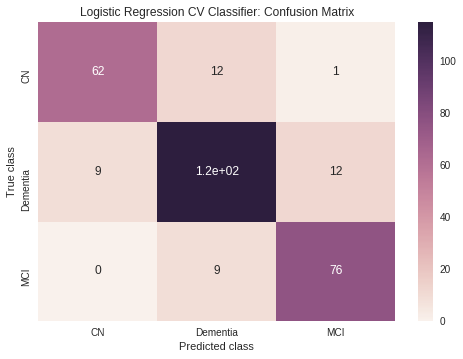

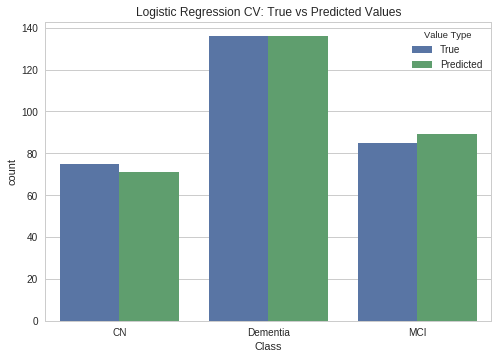

In [0]:
#Fit a Logistic Regression
logregcv = LogisticRegressionCV(Cs=10, cv=5, penalty='l2',solver='lbfgs', max_iter=1000, n_jobs=-1)

logregcv, logregcv_acc = fit_model(logregcv, 'Logistic Regression CV', ADNI_df, to_OHE, non_pred, sparse)

### KNN


The accuracy of KNN is 0.726351



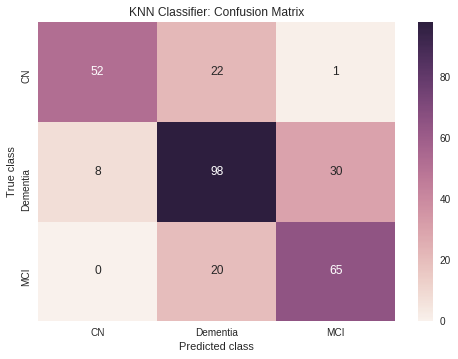

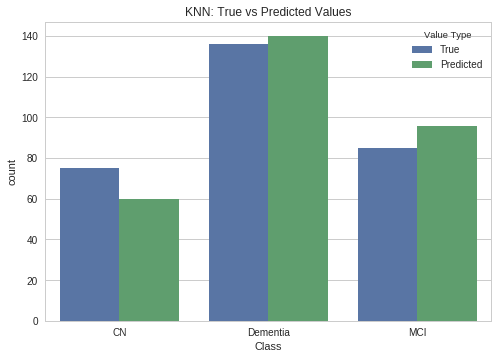

In [0]:
#Fit KNN Regression
knn = KNeighborsClassifier(n_neighbors=5)  

knn, knn_acc = fit_model(knn, 'KNN', ADNI_df, to_OHE, non_pred, sparse)

### LDA

The accuracy of LDA is 0.766892



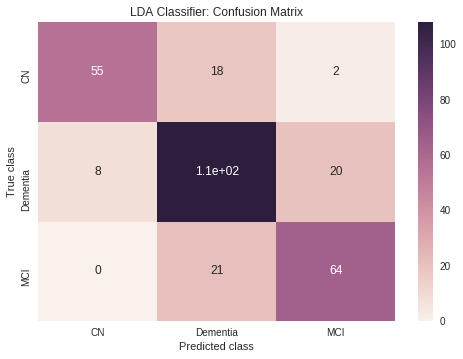

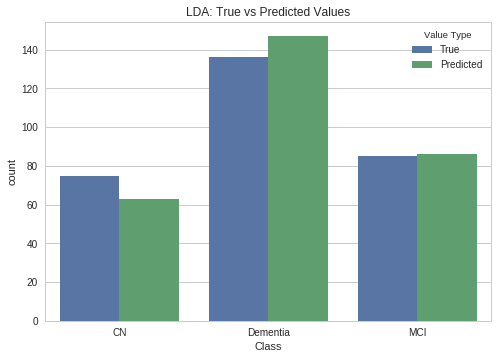

In [0]:
#Fit LDA Classifier
LDA = LinearDiscriminantAnalysis()

LDA, LDA_acc = fit_model(LDA, 'LDA', ADNI_df, to_OHE, non_pred, sparse)

### QDA

The accuracy of QDA is 0.405405



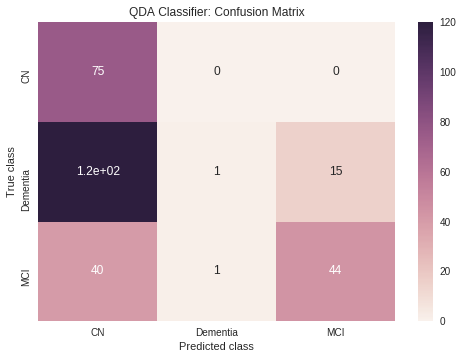

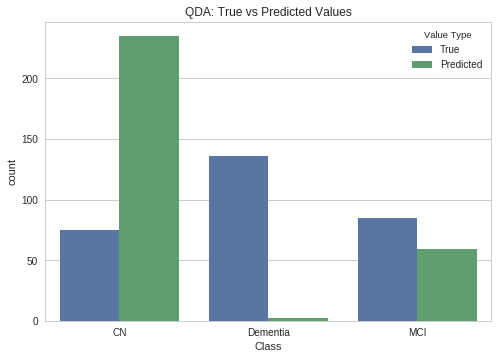

In [0]:
#Fit QDA Classifier
QDA = QuadraticDiscriminantAnalysis()

QDA, QDA_acc = fit_model(QDA, 'QDA', ADNI_df, to_OHE, non_pred, sparse)

### Decision Trees

Decision Trees are comprised of a nested series of comparisons between predictors that are compared to threshold values.  Each decision, or split, involves a single feature and a threshold value that separates the classes.  The "tree" takes an upside down appearance with the root class at the top, and subsequent branches and nodes becoming more "pure" for a specific class as we move down.  

Here we will fit a simple decision tree model to our data and stop it at a max depth of 10 to help mitigate overfitting.  We'll then graph what the tree looks like and plot the summary of the performance.

The accuracy of Decision Tree: MaxDepth=10 is 0.861486



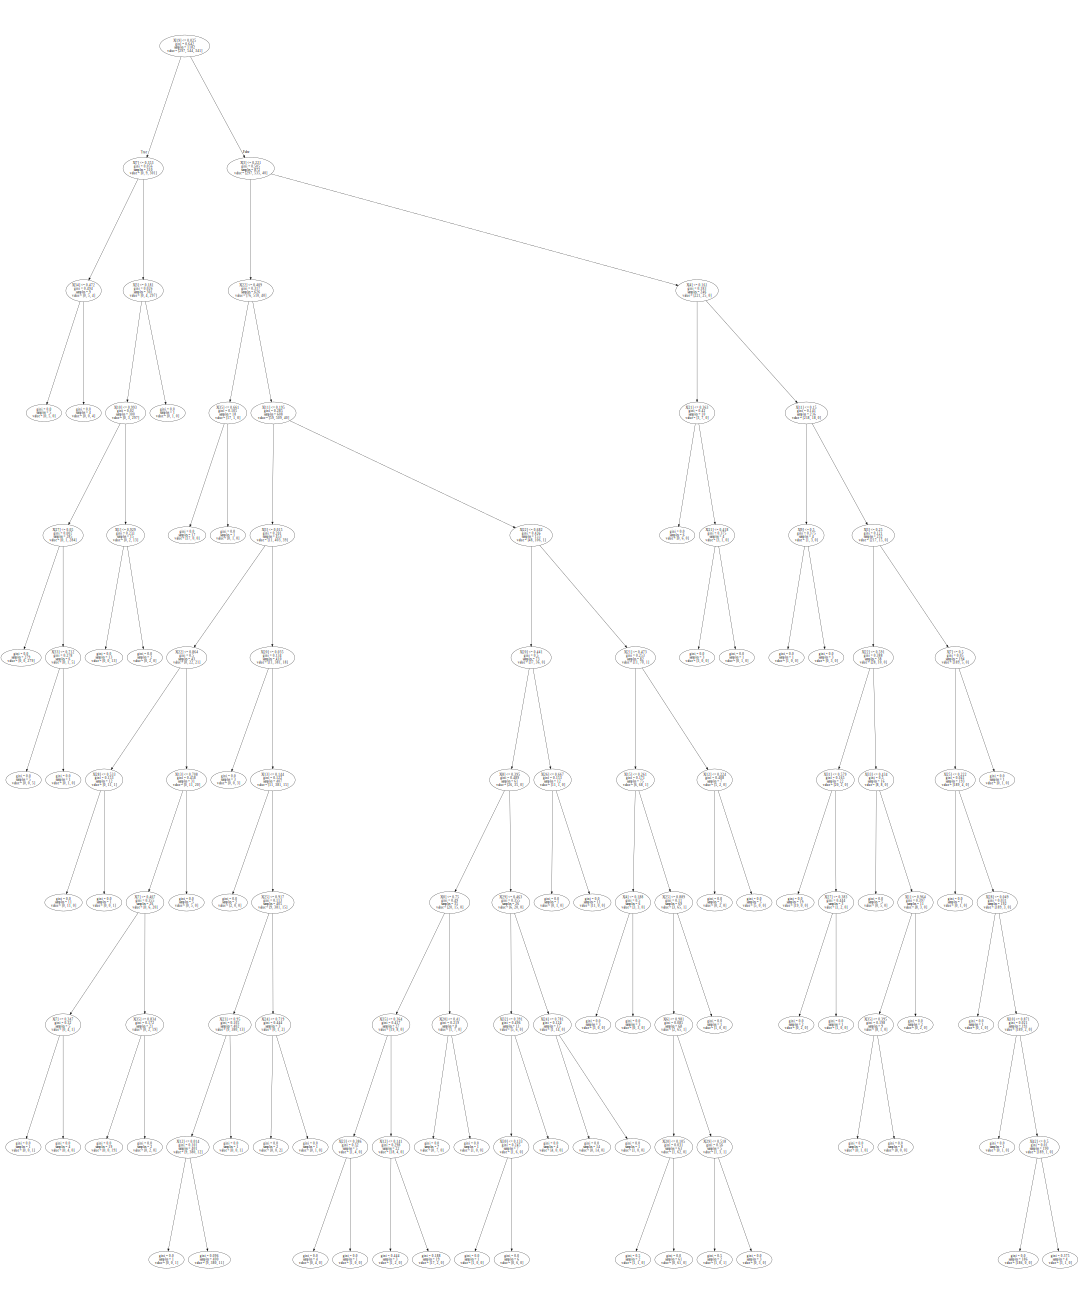

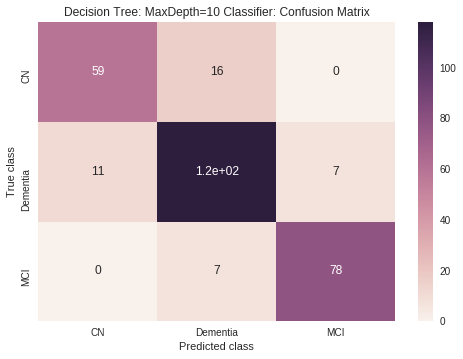

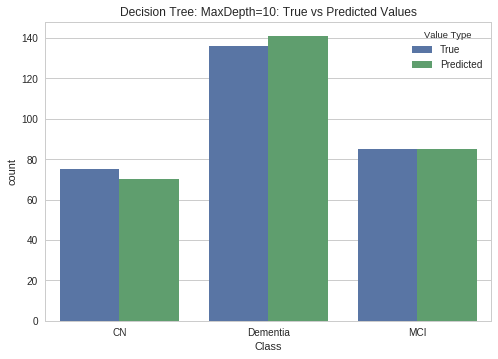

In [0]:
#lets try again with a less overfit tree
clf10 = DecisionTreeClassifier(max_depth=10)

clf10, clf10_acc = fit_model(clf10, 'Decision Tree: MaxDepth=10', ADNI_df, to_OHE, non_pred, sparse, graphviz_plot=True)


### Random Forest

The decision trees performed fairly well at classification, but let's see if we can do better using a random forest.  This combines random combinations of decision trees along with random subsets of predictors to create an ensemble model with increased predictive value over any of the base simple models.  

The accuracy of Random Forest is 0.878378



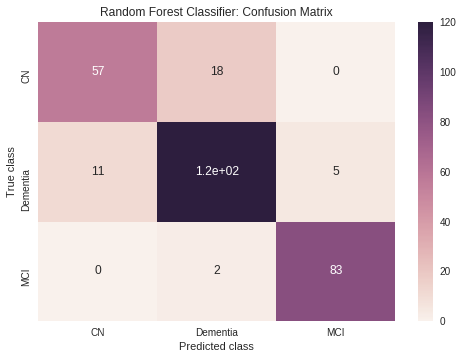

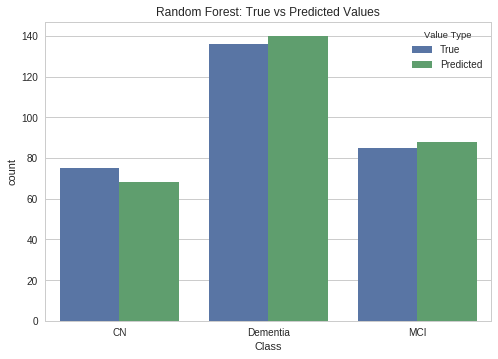

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(n_estimators=100, max_depth=None)
rf_model, rf_model_acc = fit_model(rf_model, 'Random Forest', ADNI_df, to_OHE, non_pred, sparse)

### Neural Network



In addition to traditional regression types, we also investigated two simple neural networks.  Multi-Layer-Perceptrons known as (MLPs) use forward propagation and automatic differentiation in order to learn weights between connected node models.  This approach can be useful when working with complication correlations.

#### Preprocessing

Some slight preprocessing is required to build out a connected neural network on our data.  One of the main design choices we made was to one hot encode our three classes of DX's, use Min-Max Scalar to put all of our data in the range of [0,1] and fillna with a mean imputation.

In [0]:
viscode_select='m12'
truth='DX'

#Take only one year visits and DXs with non-NaN values
ADNI_selected = ADNI_df.loc[ADNI_df['VISCODE'] == viscode_select]
ADNI_selected = ADNI_selected.dropna(subset = [truth])

#Define predictors and output
y = ADNI_selected[truth]
X = ADNI_selected.drop(sparse,axis = 1)
X = X.drop(non_pred,axis = 1)

#Replace NaNs in non-categorical data
X_float=X.drop(to_OHE,axis=1)
X_float = X_float.fillna(X_float.mean())

scaled_values = MinMaxScaler().fit_transform(X_float)
X_float = pd.DataFrame(scaled_values, index=X_float.index, columns=X_float.columns)

#One hot encode where necessary
X_cat = pd.get_dummies(X[to_OHE])
y = pd.get_dummies(y)

X = pd.concat([X_float,X_cat], axis=1)

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Once our data has been preprocessed appropriately, we first used a very simple fully connected NN using keras.

#### MLP

We selected an appropriate input shape and several hidden layers of various dense sizes, and an output into 3 classes to predict the different Dxs:

In [0]:
inp = Input(shape = (X_train.shape[1],))
x = Dense(200, activation='relu')(inp)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='sigmoid')(x)

model = Model(inputs=inp, outputs= x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 53)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 200)               10800     
_________________________________________________________________
dense_37 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_38 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_39 (Dense)             (None, 128)               6528      
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 387       
Total params: 42,865
Trainable params: 42,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs = 20, validation_split=0.2)

NN_acc = model.evaluate(X_test, y_test)[1]

Train on 945 samples, validate on 237 samples
Epoch 1/20
945/945 [==============================] - 1s 659us/step - loss: 0.3946 - acc: 0.3661 - val_loss: 0.3335 - val_acc: 0.5063
Epoch 2/20
945/945 [==============================] - 0s 82us/step - loss: 0.3333 - acc: 0.5947 - val_loss: 0.3333 - val_acc: 0.5443
Epoch 3/20
945/945 [==============================] - 0s 80us/step - loss: 0.3333 - acc: 0.4138 - val_loss: 0.3332 - val_acc: 0.2574
Epoch 4/20
945/945 [==============================] - 0s 80us/step - loss: 0.3126 - acc: 0.2571 - val_loss: 0.2803 - val_acc: 0.4515
Epoch 5/20
945/945 [==============================] - 0s 77us/step - loss: 0.2808 - acc: 0.4910 - val_loss: 0.2807 - val_acc: 0.5485
Epoch 6/20
945/945 [==============================] - 0s 77us/step - loss: 0.2758 - acc: 0.5175 - val_loss: 0.2324 - val_acc: 0.5443
Epoch 7/20
945/945 [==============================] - 0s 80us/step - loss: 0.2437 - acc: 0.5693 - val_loss: 0.2339 - val_acc: 0.6624
Epoch 8/20
945/945 [==

In [0]:
NN_acc

0.7972972972972973

Our Neural Network once trained created a decently accurate model to predict our patient DX.  This could be a useful tool, however due to the lack of interpretability of NNs, very little information can be passed back to the physician regarding the importance of the different predictors.

### SVM

Support Vector Machines seek to separate date by constructing optimal hyperplanes.  Hyperplanes are n-dimensional separators that are placed to maximize the distance between the decision boundary (the hyperplane) and the classes.  The data points closest to the decision boundary are called support vectors and they are what determine the position and orientation of the hyperplane.  The distance of the support vectors to the decision boundary is minimized using a cost function.


Let's fit a simple Support Vector Classifier and see how it performs on our data. 

The accuracy of SVM is 0.868243



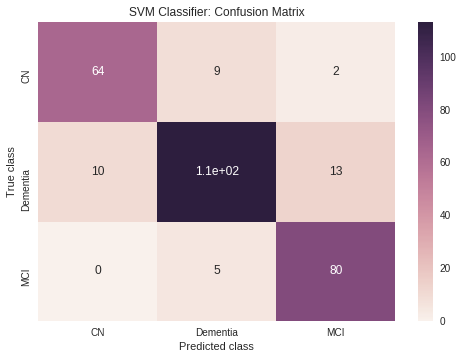

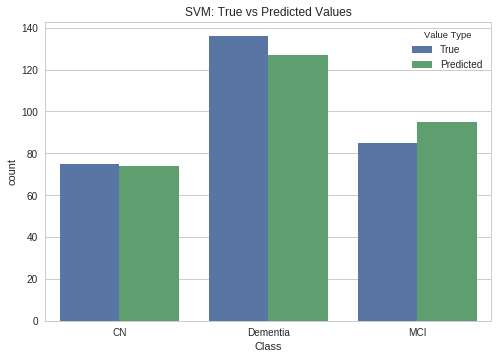

In [0]:
svc = LinearSVC(C=100, dual=False, class_weight='balanced', max_iter=10000, random_state=42)
svc, svc_acc = fit_model(svc, 'SVM', ADNI_df, to_OHE, non_pred, sparse)

Perhaps we can do better by tuning our C penalty parameter using GridSearchCV.

The accuracy of SVM - GridSearch Optimized is 0.868243



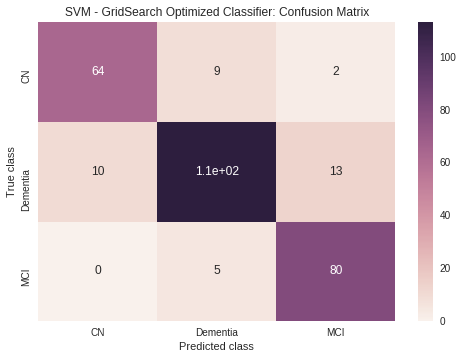

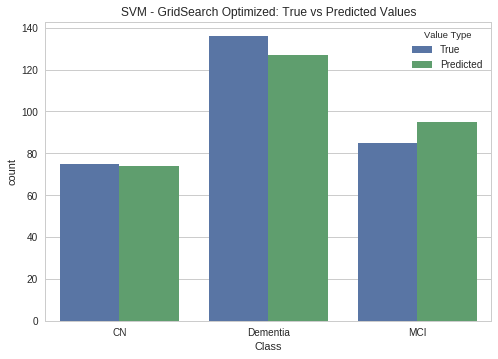

In [0]:
# Classification with a linear SVM, optimizing C using GridSearchCV
svc_grid = LinearSVC(dual=False, random_state=42, class_weight='balanced')
params_grid = {"C": [10**k for k in range(-3, 4)]}
svc_grid = GridSearchCV(svc_grid, params_grid)

svc_grid, svc_grid_acc = fit_model(svc_grid, 'SVM - GridSearch Optimized', ADNI_df, to_OHE, non_pred, sparse)

### Dimensionality Reduction Exploration: UMAP

Since we are dealing with a large number of features, it may be helpful to explore dimensionality reduction techniques to aid in both visualization and improving the performance of one of our models.  The UMAP method produces similar results to the PCA method we learned in class, but goes about reducing dimensions in a very different way.  Most dimension reduction techniques fall into two camps: matrix factorization (like PCA) and neighbor graphs (like UMAP).  UMAP is a manifold method that takes into account local relationships between neighboring points while preserving the overall global structure of the data.  More information can be found in the cited paper in the **Literature** section.

First, let's use UMAP to reduce all of our dimensions down to 2 for easy plotting and take a look at our data.  2-dimensional data is easily plotted and interpreted by people, so it's a sensible starting point

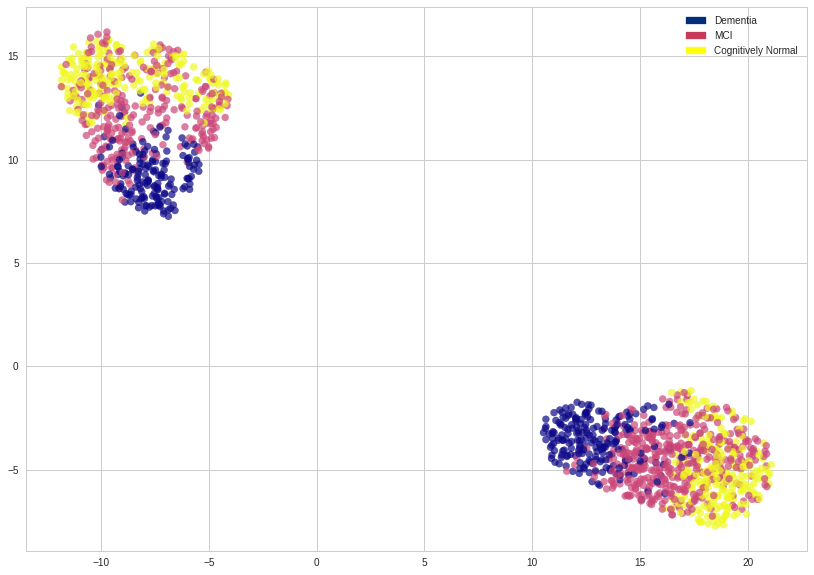

In [0]:
def plot_umap(ADNI_df: pd.DataFrame, to_OHE, non_pred, sparse):
  
  
  
  #obtain our training and test data as usual
  X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)
  
  #stack all available data together for embedding and visualization
  data=np.vstack([X_train,X_test])
  target=np.hstack([y_train,y_test])
  embedding=UMAP(random_state=42, n_components=2,n_neighbors=500,min_dist=1,metric='braycurtis').fit_transform(data)
  
  fig, ax = plt.subplots(1, figsize=(14, 10))
  ax.scatter(*embedding.T, c=target, cmap='plasma',alpha=0.7)
  
  #insert patches for legend
  blue_patch = mpatches.Patch(color='#002f7c', label='Dementia')
  red_patch = mpatches.Patch(color='#c6395a', label='MCI')
  yellow_patch = mpatches.Patch(color='#ffff0c', label='Cognitively Normal')
  plt.legend(handles=[blue_patch,red_patch,yellow_patch])
  
plot_umap(ADNI_df, to_OHE, non_pred, sparse)

Next, we will try to use UMAP and GridSearchCv to improve on the Support Vector Classifier model we fit previously.

In [0]:
# from sklearn.pipeline import Pipeline
# from umap import UMAP

# def svc_Umap(ADNI_df: pd.DataFrame, to_OHE, non_pred, sparse):
#   X_train, X_test, y_train, y_test = prepare_data(ADNI_df, to_OHE, non_pred, sparse)

#   # Classification with a linear SVM, as done before
#   svc_grid_umap = LinearSVC(dual=False, random_state=42, class_weight='balanced')
#   params_grid = {"C": [10**k for k in range(-2, 3)]}
#   clf = GridSearchCV(svc_grid_umap, params_grid, cv=5)
#   clf.fit(X_train, y_train)

#   # Transform with UMAP followed by SVM classification
#   umap = UMAP(random_state=4242, metric='minkowski', min_dist=0.5)
#   pipeline = Pipeline([("umap", umap),
#                      ("svc", svc_grid_umap)])
#   params_grid_pipeline = {"umap__n_neighbors": [5, 20,500],
#                         "umap__n_components": [2, 5, 10],
#                         "svc__C": [10**k for k in range(-2, 3)]}

#   clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline, cv=5)
#   clf_pipeline.fit(X_train, y_train)

#   print("\nSVM accuracy on the test set with raw data: {:.3f}".format(
#     clf.score(X_test, y_test)))

#   print("SVM accuracy on the test set with UMAP transformation: {:.3f}".format(
#     clf_pipeline.score(X_test, y_test)))
  
#   return clf_pipeline.score(X_test, y_test)

# UMAP_svc_acc = svc_Umap(ADNI_df, to_OHE, non_pred, sparse)

It seems that UMAP made things a bit worse for prediction in this specific case.  UMAP is usually used when there are thousands to tens of thousand predictors.  When we intially started on the project, it appeared that we would at least have thousands of predictors to model with.  But due to knowlege of the data, practical concerns and limitations of the dataset structure, we ended up with fewer predictors than we initially anticipated, making UMAP unecessary for this specific application.  It is, however, a very useful technique for true high-dimensionality problems that arise in DNA and RNA sequencing applications for which this method was initially developed for.

### Results Summary

In [0]:
summary = pd.DataFrame({'Model':['Logistic','KNN','LDA','QDA',
                                 'Decision Trees MaxDepth10','Random Forest','SVM','SVM-GridOptimized', 'Neural Network','UMAP'],
                        'Performance':[logregcv_acc,knn_acc,LDA_acc,QDA_acc,clf10_acc,rf_model_acc,svc_acc,svc_grid_acc,NN_acc,'UMAP_svc_acc']})

summary

,Model,Performance
0,Logistic,0.85473
1,KNN,0.726351
2,LDA,0.766892
3,QDA,0.405405
4,Decision Trees MaxDepth10,0.861486
5,Random Forest,0.878378
6,SVM,0.868243
7,SVM-GridOptimized,0.868243
8,Neural Network,0.797297
9,UMAP,UMAP_svc_acc


## Conclusions

In this project we have developed a model able to predict Alzheimer’s disease with a 87% accuracy based on a baseline set of tests and a second evaluation 12 months later. 

In order to get there we had to get familiar with a vast amount of data and many new concepts. We started by attempting to obtain our own merged dataset because we believed on the one hand we would be more flexible, and on the other hand we would better understand the data we are working with. However, the size of the data, the variety of formats, and the level of time and understanding required made us go with the ADNI merged data set.  But at that time we had a good understanding of the data we were dealing with and we understood how strenuous this process can be for some datasets. Still a very important part of Data Science.

After doing some standard preprocessing to the data we experimented with different models, including an unsupervised classification technique never seen in class: UMAP.  We concluded that Random Forest is the best model for predicting a correct diagnosis for patients.


## Future Steps

There are many things that we would like to do in future studies. The first one that comes to our mind is getting a better understanding of predictive power of each predictor. We could focus on particular categories (neuropsychological tests vs biomarkers vs imaging) or on particular tests within those categories (CDR vs FAQ vs MOCA). The goal would be to provide with some recommendations on the most cost effective tests or group of tests to the doctors and community. The way we could approach this is by getting a temporary slice were we have a substantial number of patient observations with tests in all categories and flattening it. We could use the median for some of the repeated tests if any in that time range. That will allow us to then play with the data by adding/removing some predictors and  fitting some of the models we have seen perform better, for example random forests.


Once the predictors are covered, another dimension we would have liked to explore is the time. We would do this by researching and applying some time series analysis approaches since this data is inherently of that nature.


For last we would like to improve the preprocessing of the data and to better tune our models. For a dataset with so many missing values a wise selection of observations and predictors, and thorough imputaton and preprocessing of the data is key for the accuracy of our models. We could try several imputation techniques like using random values or even predicting values by applying some simple models. Then when it comes to our models we feel we have a lot to tune and experiment with, specially we feel the neural networks have much more potential for this dataset that what we have seen.

## References

UMAP:  McInnes, Leland, and John Healy. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).

Harvard-IACS. "2018-CS109A" (CS-109A Course Materials). https://github.com/Harvard-IACS/2018-CS109A (2018)

ADNI Biostatistics Core Team. "ADNI Data Training Part 2". http://adni.loni.usc.edu/wp-content/uploads/2010/09/ADNI_GeneralProceduresManual.pdf (2013/08/01)

ADNI. "ADNI Procedures Manual". http://adni.loni.usc.edu/wp-content/uploads/2010/09/ADNI_GeneralProceduresManual.pdf

[ADNI (Bitbucket)](https://bitbucket.org/adni/). "ADNIMERGE" (R code). https://adni.bitbucket.io/myfunctions.R

ADNI. "ADNI Data Dictionary". http://adni.loni.usc.edu/data-dictionary-search/ (2017)
